# Merging Fire, Climate and Land Data

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.options.display.float_format = "{:,.2f}".format

## Fire data

In [11]:
file_path = '../data/fire2.csv'
fire_df = pd.read_csv(file_path)
fire_df = fire_df.sort_values(['lon_bounds','lat_bounds','year','month'])
fire_df = fire_df.reset_index()
fire_df = fire_df.drop(['index'], axis=1)
fire_df = fire_df.reindex(columns=['lon_bounds', 'lat_bounds', 'year', 'month', 'burned_area', 'fraction_of_burnable_area', 'CL'])
fire_df = fire_df.drop_duplicates(subset=['lon_bounds', 'lat_bounds', 'year', 'month'])
fire_df['month'] = fire_df['month'] + 1
fire_df

,lon_bounds,lat_bounds,year,month,burned_area,fraction_of_burnable_area,CL
0,-10.00,51.50,2001,5,0.00,0.04,0
1,-10.00,51.50,2001,6,0.00,0.04,0
2,-10.00,51.50,2001,7,0.00,0.04,0
3,-10.00,51.50,2001,8,0.00,0.04,0
4,-10.00,51.50,2002,5,0.00,0.04,0
...,...,...,...,...,...,...,...
1979635,50.00,51.75,2018,8,0.00,0.99,1
1979636,50.00,51.75,2019,5,"751,305.00",0.99,1
1979637,50.00,51.75,2019,6,0.00,0.99,1
1979638,50.00,51.75,2019,7,0.00,0.99,1


In [12]:
fire_df = fire_df.groupby(['lon_bounds','lat_bounds','year']).agg({'month':'mean', 'burned_area':'sum', 'fraction_of_burnable_area':'mean', 'CL':'mean'})
fire_df.reset_index(inplace=True)
fire_df = fire_df.drop(['month'], axis=1)
fire_df

,lon_bounds,lat_bounds,year,burned_area,fraction_of_burnable_area,CL
0,-10.00,51.50,2001,0.00,0.04,0.00
1,-10.00,51.50,2002,0.00,0.04,0.00
2,-10.00,51.50,2003,0.00,0.04,0.00
3,-10.00,51.50,2004,0.00,0.04,0.00
4,-10.00,51.50,2005,0.00,0.04,0.00
...,...,...,...,...,...,...
262834,50.00,51.75,2015,0.00,0.99,1.00
262835,50.00,51.75,2016,"482,982.00",0.99,1.00
262836,50.00,51.75,2017,"8,747,340.00",0.99,1.00
262837,50.00,51.75,2018,"9,122,992.00",0.99,1.00


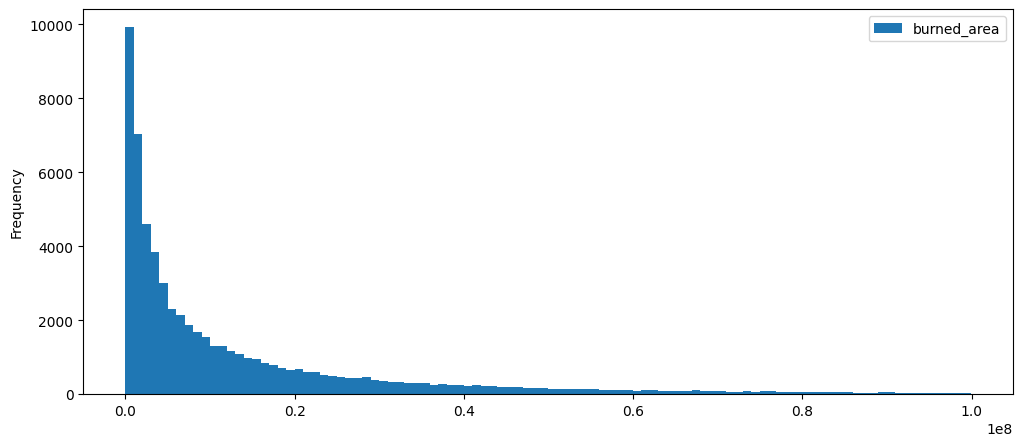

In [13]:
fire_df[(fire_df['burned_area']<=1*10**8) & (fire_df['burned_area']>0)].plot.hist(column=["burned_area"], bins=100, figsize=(12, 5));

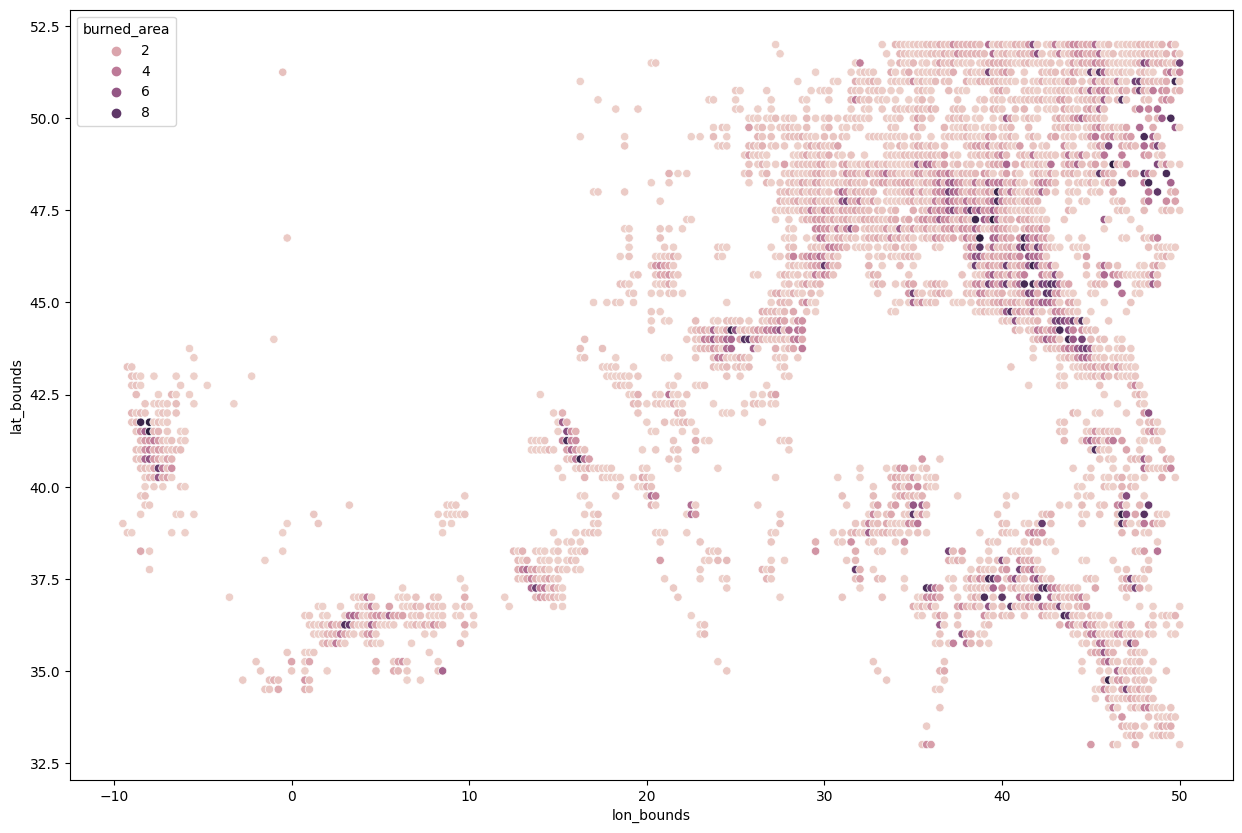

In [14]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=fire_df[(fire_df['burned_area']<=1*10**8) & (fire_df['burned_area']>0) & (fire_df['year']==2010)], x='lon_bounds', y='lat_bounds', hue = 'burned_area');

map is not complete because when preprocessing I took only values where burnable area was larger than 1 and burned area was more than 1m2

## Climate data

In [15]:
climate_df = pd.read_csv('../data/climate.csv')
climate_df = climate_df.drop(['Unnamed: 0'], axis=1)
climate_df = climate_df.rename(columns={"lon": "lon_bounds", "lat": "lat_bounds"})
climate_df

,lon_bounds,lat_bounds,year,tas_5,tasmax_5,pr_5,tas_6,tasmax_6,pr_6,tas_7,tasmax_7,pr_7,tas_8,tasmax_8,pr_8
0,-10.00,33.00,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-10.00,33.25,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-10.00,33.50,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-10.00,33.75,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-10.00,34.00,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352578,50.00,51.00,2019,19.90,26.30,24.60,24.00,31.30,19.60,23.60,30.20,35.00,20.80,27.30,18.10
352579,50.00,51.25,2019,19.20,25.60,27.90,22.90,30.10,21.70,22.80,29.20,37.50,19.90,26.10,24.50
352580,50.00,51.50,2019,19.20,25.60,27.90,22.90,30.10,21.70,22.80,29.20,37.50,19.90,26.10,24.50
352581,50.00,51.75,2019,18.80,25.20,29.50,22.40,29.30,22.80,22.40,28.60,40.50,19.60,25.50,30.20


## Land data

In [16]:
land_df = pd.read_csv('../data/satellite_landcover_dataset.csv')
land_df = land_df.drop(['lat_bounds', 'lon_bounds'], axis=1)
land_df.rename(columns={'lat': 'lat_bounds', 'lon': 'lon_bounds', 'time': 'year'}, inplace=True)
land_df = land_df.reindex(columns=['lon_bounds', 'lat_bounds', 'year', 'lccs_class', 'processed_flag', 'current_pixel_state', 'observation_count', 'change_count'])
land_df = land_df.sort_values(['lon_bounds','lat_bounds','year'])
land_df = land_df[land_df['year'] != 2020]
land_df = land_df.drop_duplicates()
land_df

,lon_bounds,lat_bounds,year,lccs_class,processed_flag,current_pixel_state,observation_count,change_count
12314,-10.00,33.00,2001,210,1.00,0.00,0,0
61754,-10.00,33.00,2002,210,1.00,0.00,0,0
98866,-10.00,33.00,2003,210,1.00,0.00,0,0
123655,-10.00,33.00,2004,210,1.00,0.00,0,0
160770,-10.00,33.00,2005,210,1.00,0.00,0,0
...,...,...,...,...,...,...,...,...
531908,50.00,52.00,2015,10,1.00,1.00,253,0
569023,50.00,52.00,2016,10,1.00,1.00,253,0
618462,50.00,52.00,2017,10,1.00,1.00,253,0
655575,50.00,52.00,2018,10,1.00,1.00,253,0


## Merging data

In [17]:
print(fire_df['lon_bounds'].unique().shape[0])
print(fire_df['lat_bounds'].unique().shape[0])
print(fire_df['year'].unique().shape[0])
print(climate_df['lon_bounds'].unique().shape[0])
print(climate_df['lat_bounds'].unique().shape[0])
print(climate_df['year'].unique().shape[0])
print(land_df['lon_bounds'].unique().shape[0])
print(land_df['lat_bounds'].unique().shape[0])
print(land_df['year'].unique().shape[0])

241
77
19
241
77
19
241
77
19


In [29]:
fire_climate_df = fire_df.merge(
    climate_df,
    how='left',
    on=['lat_bounds', 'lon_bounds', 'year']
    )

all_df = fire_climate_df.merge(
    land_df,
    how='left',
    on=['lat_bounds', 'lon_bounds', 'year']
    )

all_df

,lon_bounds,lat_bounds,year,burned_area,fraction_of_burnable_area,CL,tas_5,tasmax_5,pr_5,tas_6,...,tasmax_7,pr_7,tas_8,tasmax_8,pr_8,lccs_class,processed_flag,current_pixel_state,observation_count,change_count
0,-10.00,51.50,2001,0.00,0.04,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,210,1.00,2.00,202,0
1,-10.00,51.50,2002,0.00,0.04,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,210,1.00,2.00,202,0
2,-10.00,51.50,2003,0.00,0.04,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,210,1.00,2.00,202,0
3,-10.00,51.50,2004,0.00,0.04,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,210,1.00,2.00,202,0
4,-10.00,51.50,2005,0.00,0.04,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,210,1.00,2.00,202,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262834,50.00,51.75,2015,0.00,0.99,1.00,17.60,23.30,34.40,24.50,...,28.00,39.20,20.50,26.90,17.40,10,1.00,1.00,263,0
262835,50.00,51.75,2016,"482,982.00",0.99,1.00,17.30,23.40,45.90,20.40,...,30.10,38.40,25.20,32.40,17.00,10,1.00,1.00,263,0
262836,50.00,51.75,2017,"8,747,340.00",0.99,1.00,15.10,20.90,37.20,18.70,...,29.20,23.70,23.70,30.00,6.70,10,1.00,1.00,263,0
262837,50.00,51.75,2018,"9,122,992.00",0.99,1.00,18.00,24.80,21.60,20.00,...,31.30,53.40,21.50,28.50,8.30,10,1.00,1.00,263,0


In [30]:
all_df_filtered = all_df.dropna()
all_df_filtered.reset_index(inplace=True)
all_df_filtered = all_df_filtered.drop(['index'], axis=1)
all_df_filtered

,lon_bounds,lat_bounds,year,burned_area,fraction_of_burnable_area,CL,tas_5,tasmax_5,pr_5,tas_6,...,tasmax_7,pr_7,tas_8,tasmax_8,pr_8,lccs_class,processed_flag,current_pixel_state,observation_count,change_count
0,-10.00,51.75,2001,0.00,0.45,1.00,12.30,16.50,39.00,13.40,...,18.80,79.00,15.30,18.90,102.10,130,1.00,1.00,89,0
1,-10.00,51.75,2002,0.00,0.45,1.00,11.30,14.80,153.70,13.00,...,17.70,68.70,15.40,18.90,56.40,130,1.00,1.00,89,0
2,-10.00,51.75,2003,0.00,0.45,1.00,11.10,14.50,119.20,14.30,...,19.10,87.20,16.60,20.50,17.20,130,1.00,1.00,89,0
3,-10.00,51.75,2004,0.00,0.45,1.00,11.50,15.30,46.50,14.40,...,18.20,62.90,16.00,19.50,109.30,130,1.00,1.00,89,0
4,-10.00,51.75,2005,0.00,0.45,1.00,10.80,14.30,109.20,14.60,...,19.10,71.70,15.60,19.20,56.90,130,1.00,1.00,89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254132,50.00,51.75,2015,0.00,0.99,1.00,17.60,23.30,34.40,24.50,...,28.00,39.20,20.50,26.90,17.40,10,1.00,1.00,263,0
254133,50.00,51.75,2016,"482,982.00",0.99,1.00,17.30,23.40,45.90,20.40,...,30.10,38.40,25.20,32.40,17.00,10,1.00,1.00,263,0
254134,50.00,51.75,2017,"8,747,340.00",0.99,1.00,15.10,20.90,37.20,18.70,...,29.20,23.70,23.70,30.00,6.70,10,1.00,1.00,263,0
254135,50.00,51.75,2018,"9,122,992.00",0.99,1.00,18.00,24.80,21.60,20.00,...,31.30,53.40,21.50,28.50,8.30,10,1.00,1.00,263,0


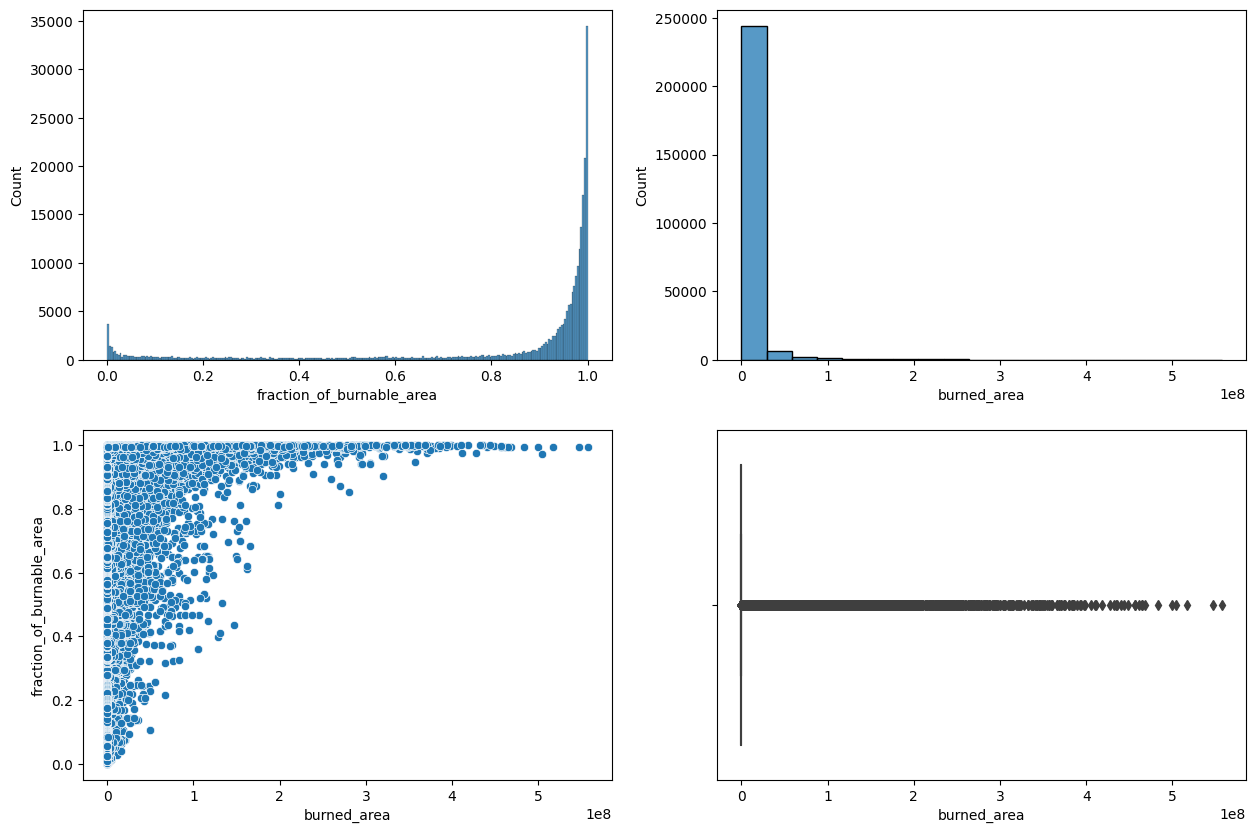

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(all_df_filtered['fraction_of_burnable_area'], ax=ax1)
sns.histplot(all_df_filtered['burned_area'], ax=ax2)
sns.scatterplot(data=all_df_filtered, x='burned_area', y='fraction_of_burnable_area', ax=ax3)
sns.boxplot(data = all_df_filtered, x= 'burned_area', ax=ax4)
plt.show();

In [32]:
all_df_filtered.to_csv('../data/all_merged.csv')